# some Examples of using PySpark
### This is very preliminary. I just want to illustrate how to use it.
* initially get some info about the spark context

In [5]:
# make sure the spark context exists
sc

In [6]:
# what is the master for this 
sc.master

u'yarn-client'

## parallelizing a Count

In [1]:
sc.parallelize(range(1000)).count()

1000

#### Approximating $\pi$

In [9]:
partitions = 3
n=100000*partitions

In [8]:
from random import random
from operator import add
def approx_pi(_):
    x = random()*2 -1
    y = random()*2 -1
    return 1 if x**2+y**2  < 1 else 0

In [11]:
count = sc.parallelize(xrange(1,n+1),partitions).map(approx_pi).reduce(add)
print "Pi is roughly %f" % (4.0*count/n)

Pi is roughly 3.141787


### basic word counts

In [8]:
# by default it draws from /user/xxx/
infile = 'hdfs://nameservice1/data/discovery/claimsff/derived/npi_study/plcy_nm_insrd_addr/plcy_nm_insrd_addr'

In [9]:
f = sc.textFile(infile)

1. take a peak at the file
2. Find out how many lines are in this file.
3. split on spaces and do word count

In [10]:
for x in f.take(30):
    print x

000000029    2012-05-05 00:00:25.000104N1CONVERSION                    2012-05-03 15:00:002012-05-03 15:00:009999-12-31 23:59:599999-12-31 23:59:59ECSCONV78 2012-05-03 15:00:0078NNN
000000029    2012-05-05 00:00:25.000104N1CONVERSION                    2012-05-03 15:00:002012-05-03 15:00:009999-12-31 23:59:599999-12-31 23:59:59ECSCONV78 2012-05-03 15:00:0078NNN
000000029    2012-05-05 00:00:25.000104N1CONVERSION                    2012-05-03 15:00:002012-05-03 15:00:009999-12-31 23:59:599999-12-31 23:59:59ECSCONV78 2012-05-03 15:00:0078NNN
000000029    2012-05-05 00:00:25.000104N1CONVERSION                    2012-05-03 15:00:002012-05-03 15:00:009999-12-31 23:59:599999-12-31 23:59:59ECSCONV78 2012-05-03 15:00:0078NNN
000000029    2012-05-05 00:00:25.000104N1CONVERSION                    2012-05-03 15:00:002012-05-03 15:00:009999-12-31 23:59:599999-12-31 23:59:59ECSCONV78 2012-05-03 15:00:0078NNN
000000029    2012-0

In [11]:
print "In this file there are {0} lines".format(f.count())

In this file there are 156197272 lines


### count the lineLengths of this file (and persist this to use it later)


In [17]:
addr_line_lengths = f.map(lambda s: len(s))
addr_line_lengths.persist()

PythonRDD[9] at RDD at PythonRDD.scala:43

In [18]:
totalLength = addr_line_lengths.reduce(lambda a, b: a+b)

In [20]:
totalLength/f.count()

202

In [13]:
x.split('\x19')

[u'000774236V   ',
 u'2012-04-13 22:10:36.000331',
 u'C',
 u'3',
 u'BROKEN ARROW OK  74014-1937   ',
 u'2012-04-12 15:00:00',
 u'2012-04-12 15:00:00',
 u'9999-12-31 23:59:59',
 u'9999-12-31 23:59:59',
 u'ECSCONV26 ',
 u'2012-04-12 15:00:00',
 u'26',
 u'N',
 u'N',
 u'N']

# assign a structure based upon the defined schema?
Per stackoverflow comment (http://stackoverflow.com/questions/26177307/spark-and-python-use-custom-file-format-generator-as-input-for-rdd)  it seems like the fasted way to do this is to load it and them apply the logic to that.

* or Is using sparkSQL better?

* in my case the data file may be fixed-width-delimited

In [21]:
plcy_named_insured_schema = [u'plcy_id',
 u'plcy_snpst_tstmp',
 u'nm_addr_type_cd',
 u'srt_seq_num',
 u'addr_line_txt',
 u'src_insrt_tstmp',
 u'fdw_insrt_tstmp',
 u'fdw_rplc_tstmp',
 u'src_rplc_tstmp',
 u'data_cntxt_cd',
 u'stg_insrt_tstmp',
 u'src_oprtn_cd',
 u'src_rplc_ind',
 u'fdw_rplc_ind',
 u'src_sys_dlte_ind']

In [38]:
schema_string = ' '.join(plcy_named_insured_schema)


u'plcy_id plcy_snpst_tstmp nm_addr_type_cd srt_seq_num addr_line_txt src_insrt_tstmp fdw_insrt_tstmp fdw_rplc_tstmp src_rplc_tstmp data_cntxt_cd stg_insrt_tstmp src_oprtn_cd src_rplc_ind fdw_rplc_ind src_sys_dlte_ind'

In [57]:
parts = f.map(lambda l: l.split("\x19"))
addresses = parts.map(lambda p: Row(plcy_id=p[0], plcy_snpst_tstmp=p[1], nm_addr_type_cd=p[2],srt_seq_num=int(p[3]),
                                    addr_line_txt=p[4],src_insrt_tstmp=p[5],fdw_insrt_tstmp=p[6],fdw_rplc_tstmp=p[7],
                                    src_rplc_tstmp=p[8],data_cntxt_cd=p[9],stg_insrt_tstmp=p[10],src_oprtn_cd=p[11],
                                    src_rplc_ind=p[12],fdw_rplc_ind=p[13],src_sys_dlte_ind=p[14]))

In [59]:
addresses.first()

Row(addr_line_txt=u'CONVERSION                    ', data_cntxt_cd=u'ECSCONV78 ', fdw_insrt_tstmp=u'2012-05-03 15:00:00', fdw_rplc_ind=u'N', fdw_rplc_tstmp=u'9999-12-31 23:59:59', nm_addr_type_cd=u'N', plcy_id=u'000000029    ', plcy_snpst_tstmp=u'2012-05-05 00:00:25.000104', src_insrt_tstmp=u'2012-05-03 15:00:00', src_oprtn_cd=u'78', src_rplc_ind=u'N', src_rplc_tstmp=u'9999-12-31 23:59:59', src_sys_dlte_ind=u'N', srt_seq_num=1, stg_insrt_tstmp=u'2012-05-03 15:00:00')

In [60]:
for x in addresses.take(30):
    print x

Row(addr_line_txt=u'CONVERSION                    ', data_cntxt_cd=u'ECSCONV78 ', fdw_insrt_tstmp=u'2012-05-03 15:00:00', fdw_rplc_ind=u'N', fdw_rplc_tstmp=u'9999-12-31 23:59:59', nm_addr_type_cd=u'N', plcy_id=u'000000029    ', plcy_snpst_tstmp=u'2012-05-05 00:00:25.000104', src_insrt_tstmp=u'2012-05-03 15:00:00', src_oprtn_cd=u'78', src_rplc_ind=u'N', src_rplc_tstmp=u'9999-12-31 23:59:59', src_sys_dlte_ind=u'N', srt_seq_num=1, stg_insrt_tstmp=u'2012-05-03 15:00:00')
Row(addr_line_txt=u'CONVERSION                    ', data_cntxt_cd=u'ECSCONV78 ', fdw_insrt_tstmp=u'2012-05-03 15:00:00', fdw_rplc_ind=u'N', fdw_rplc_tstmp=u'9999-12-31 23:59:59', nm_addr_type_cd=u'N', plcy_id=u'000000029    ', plcy_snpst_tstmp=u'2012-05-05 00:00:25.000104', src_insrt_tstmp=u'2012-05-03 15:00:00', src_oprtn_cd=u'78', src_rplc_ind=u'N', src_rplc_tstmp=u'9999-12-31 23:59:59', src_sys_dlte_ind=u'N', srt_seq_num=1, stg_insrt_tstmp=u'2012-05-03 15:00:00')
Row(addr_line_txt=u'CONVERSION                    ', dat

In [31]:
sqlContext = SQLContext(sc)
schemaAddresses = sqlContext.inferSchema(addresses)

In [61]:
schemaAddresses.printSchema()

root
 |-- addr_line_txt: string (nullable = true)
 |-- data_cntxt_cd: string (nullable = true)
 |-- fdw_insrt_tstmp: string (nullable = true)
 |-- fdw_rplc_ind: string (nullable = true)
 |-- fdw_rplc_tstmp: string (nullable = true)
 |-- nm_addr_type_cd: string (nullable = true)
 |-- plcy_id: string (nullable = true)
 |-- plcy_snpst_tstmp: string (nullable = true)
 |-- src_insrt_tstmp: string (nullable = true)
 |-- src_oprtn_cd: string (nullable = true)
 |-- src_rplc_ind: string (nullable = true)
 |-- src_rplc_tstmp: string (nullable = true)
 |-- src_sys_dlte_ind: string (nullable = true)
 |-- srt_seq_num: integer (nullable = true)
 |-- stg_insrt_tstmp: string (nullable = true)



In [62]:
schemaAddresses.registerTempTable("addresses")
# next try SQL

In [66]:
active_addresses = sqlContext.sql("SELECT plcy_id,addr_line_txt from addresses WHERE fdw_rplc_ind like 'N'")

In [67]:
active_addresses.take(30)

[Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    ', addr_line_txt=u'CONVERSION                    '),
 Row(plcy_id=u'000000029    

In [75]:
active_address_pairs = active_addresses.map(lambda x: (x.split(",")[0],x.split(",")[1]))#polcy_id,x.addr_line_txt)

In [76]:
active_address_pairs.take(10)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 22.0 failed 4 times, most recent failure: Lost task 0.3 in stage 22.0 (TID 786, da74wbdn21.opr.statefarm.org): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/data/hadoop-data/4/yarn/nm/usercache/kesj/filecache/797/spark-assembly-1.2.0-cdh5.3.0-hadoop2.5.0-cdh5.3.0.jar/pyspark/worker.py", line 107, in main
    process()
  File "/data/hadoop-data/4/yarn/nm/usercache/kesj/filecache/797/spark-assembly-1.2.0-cdh5.3.0-hadoop2.5.0-cdh5.3.0.jar/pyspark/worker.py", line 98, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/data/hadoop-data/4/yarn/nm/usercache/kesj/filecache/797/spark-assembly-1.2.0-cdh5.3.0-hadoop2.5.0-cdh5.3.0.jar/pyspark/serializers.py", line 227, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/cloudera/parcels/CDH-5.3.0-1.cdh5.3.0.p0.30/lib/spark/python/pyspark/rdd.py", line 1107, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-75-586927db7b4f>", line 1, in <lambda>
AttributeError: 'Row' object has no attribute 'split'

	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:137)
	at org.apache.spark.api.python.PythonRDD$$anon$1.<init>(PythonRDD.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:96)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:263)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:230)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:61)
	at org.apache.spark.scheduler.Task.run(Task.scala:56)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:196)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1214)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1203)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1202)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1202)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:696)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:696)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:696)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessActor$$anonfun$receive$2.applyOrElse(DAGScheduler.scala:1420)
	at akka.actor.ActorCell.receiveMessage(ActorCell.scala:498)
	at akka.actor.ActorCell.invoke(ActorCell.scala:456)
	at akka.dispatch.Mailbox.processMailbox(Mailbox.scala:237)
	at akka.dispatch.Mailbox.run(Mailbox.scala:219)
	at akka.dispatch.ForkJoinExecutorConfigurator$AkkaForkJoinTask.exec(AbstractDispatcher.scala:386)
	at scala.concurrent.forkjoin.ForkJoinTask.doExec(ForkJoinTask.java:260)
	at scala.concurrent.forkjoin.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:1339)
	at scala.concurrent.forkjoin.ForkJoinPool.runWorker(ForkJoinPool.java:1979)
	at scala.concurrent.forkjoin.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:107)


#### try without the sqlschema

In [77]:
parts = f.map(lambda l: l.split("\x19"))
active_address_pairs = parts.filter(lambda p: p[13]=='N').map(lambda p: (p[0],p[4]))

In [78]:
active_address_pairs.count()

156197272

In [101]:
# group all the corresponding values into a given value (namely plcy_id)
address_by_plcy_id = active_address_pairs.map(lambda (x,y): (x, [y])).reduceByKey(lambda p,q: p+q)#.collect()

In [102]:
address_by_plcy_id.take(10)

[(u'35BQT3010    ',
  [u'216 N 2ND ST                  ',
   u'TIPP CITY OH 453711910        ',
   u'HOLZFASTER, NORMAN & SHANNON  ',
   u'216 N 2ND ST                  ',
   u'TIPP CITY OH 453711910        ',
   u'HOLZFASTER, NORMAN & SHANNON  ']),
 (u'43B5H3437    ',
  [u'2110 MACK LN                  ',
   u'DALLAS TX 752279217           ',
   u'WILLIAMS, CAROLYN             ']),
 (u'920243759    ',
  [u'18316 ORIOLE RD               ',
   u'18316 ORIOLE RD               ',
   u'FORT MYERS FL  33967-3253     ',
   u'FORT MYERS FL  33967-3253     ',
   u'NELSON, MERCELON              ',
   u'NELSON, MERCELON              ',
   u'17369 ORIOLE RD               ',
   u'17369 ORIOLE RD               ',
   u'FORT MYERS FL  33967-5102     ',
   u'FORT MYERS FL  33967-5102     ',
   u'NELSON, MERCELON              ',
   u'NELSON, MERCELON              ']),
 (u'154151201    ',
  [u'303 S COLLEGE ST              ',
   u'OPP AL  36467-2254            ',
   u'EDWARDS, WILLIAM              ']),


## so that works to group by policy id!!
* next I want just the set of values -- i.e. remove redudancies

In [29]:
for i in xrange(0,len(plcy_named_insured_schema)):
    print "{0}=p[{1}],".format(plcy_named_insured_schema[i],i)

plcy_id=p[0],
plcy_snpst_tstmp=p[1],
nm_addr_type_cd=p[2],
srt_seq_num=p[3],
addr_line_txt=p[4],
src_insrt_tstmp=p[5],
fdw_insrt_tstmp=p[6],
fdw_rplc_tstmp=p[7],
src_rplc_tstmp=p[8],
data_cntxt_cd=p[9],
stg_insrt_tstmp=p[10],
src_oprtn_cd=p[11],
src_rplc_ind=p[12],
fdw_rplc_ind=p[13],
src_sys_dlte_ind=p[14],


In [41]:
from collections import defaultdict

def define_plcy_addrs_schema(s):
    delimiter = '\x19'
    parts = s.split()
    y = defaultdict(lambda: '')
    for i in xrange(0,len(parts)):
        #print plcy_named_insured_schema[i],parts[i]
        y[plcy_named_insured_schema[i]] = parts[i]
    #y = [(plcy_named_insured_schema[i] = parts[i]) for i in xrange(0,len(parts))]
    #y = plcy_named_insured_schema[i]
    return y

In [53]:
f.first()

u'000000029    \x192012-05-05 00:00:25.000104\x19N\x191\x19CONVERSION                    \x192012-05-03 15:00:00\x192012-05-03 15:00:00\x199999-12-31 23:59:59\x199999-12-31 23:59:59\x19ECSCONV78 \x192012-05-03 15:00:00\x1978\x19N\x19N\x19N'

In [56]:
parts.first()

[u'000000029    ',
 u'2012-05-05 00:00:25.000104',
 u'N',
 u'1',
 u'CONVERSION                    ',
 u'2012-05-03 15:00:00',
 u'2012-05-03 15:00:00',
 u'9999-12-31 23:59:59',
 u'9999-12-31 23:59:59',
 u'ECSCONV78 ',
 u'2012-05-03 15:00:00',
 u'78',
 u'N',
 u'N',
 u'N']

In [46]:
addresses = f.map(define_plcy_addrs_schema)

## how about parsing the clm file

In [14]:
claims_input_columns_format = [u'clm_id',
 u'clm_grp_id',
 u'lgcy_clm_sys_id',
 u'clm_st_cd',
 u'st_asgn_st_cd',
 u'clm_num',
 u'prod_line_cd',
 u'cfdtl_levl_cd',
 u'clm_file_type_cd',
 u'clm_rcrd_tstmp',
 u'clm_rcrd_tmzn_cd',
 u'clm_rcrd_offst_tmzn_cnt',
 u'clm_stts_cd',
 u'clm_stts_tstmp',
 u'clm_stts_tmzn_cd',
 u'clm_stts_offst_tmzn_cnt',
 u'st_asgn_clm_num',
 u'rcrd_only_ind',
 u'dup_clm_ind',
 u'clm_cov_form_prnt_ind',
 u'siu_ind',
 u'maint_dt',
 u'conv_num',
 u'los_occr_dt',
 u'los_tm',
 u'los_rpt_dt',
 u'iso_infrm_dt',
 u'iso_init_send_ind',
 u'fatal_exst_ind',
 u'asgne_orgzn_id',
 u'app_cd',
 u'app_ver_cd',
 u'user_type_cd',
 u'los_type_cd',
 u'los_init_sgnon_id',
 u'los_init_party_busn_id',
 u'los_init_tstmp',
 u'los_sbmtr_sgnon_id',
 u'los_sbmt_sfx_cd',
 u'los_sbmt_party_busn_id',
 u'los_sbmt_tstmp',
 u'los_sbmtr_area_cd',
 u'los_sbmtr_phon_num',
 u'plcy_pre_poplt_ind',
 u'send_to_undwr_ind',
 u'asgn_to_fld_ind',
 u'fast_trk_type_cd',
 u'max_prtpt_id',
 u'rpt_agt_st_cd',
 u'rpt_agt_cd',
 u'rpt_agt_nm',
 u'party_busn_id',
 u'govt_body_rpt_num',
 u'govt_body_rpt_made_ind',
 u'rpt_govt_body_nm',
 u'govt_body_rpt_dt',
 u'govt_body_rpt_tm',
 u'los_loc_city_nm',
 u'los_loc_stret_nm',
 u'los_loc_st_cd',
 u'rpt_agt_area_cd',
 u'los_loc_cntry_cd',
 u'rpt_agt_phone_num',
 u'los_loc_cnty_nm',
 u'los_loc_zip_cd',
 u'stat_rpt_unit_orgzn_id',
 u'lgcy_cat_cd',
 u'los_sbmtr_first_nm',
 u'los_sbmtr_mid_nm',
 u'los_sbmtr_last_nm',
 u'siu_invsgr_orgzn_id',
 u'sys_prcs_cd',
 u'los_loc_desc_txt',
 u'los_desc_txt',
 u'src_insrt_tstmp',
 u'fdw_insrt_tstmp',
 u'fdw_rplc_tstmp',
 u'src_rplc_tstmp',
 u'asgn_orgzn_party_busn_id',
 u'rpt_agt_party_busn_id',
 u'src_oprtn_cd',
 u'clm_busn_id',
 u'fraud_ring_invsg_ind',
 u'data_cntxt_cd',
 u'stg_insrt_tstmp',
 u'src_rplc_ind',
 u'fdw_rplc_ind',
 u'src_sys_dlte_ind',
 u'iso_conv_clm_ind']

In [111]:
claims_input_columns_format.index('los_tm')

24

In [ ]:
#### apply filters as i import it
* los_loc_st_cd =='MI'

### group by clm_id
* keep 

In [15]:
from pyspark.sql import SQLContext, Row

In [112]:
lines = sc.textFile("hdfs://nameservice1/data/discovery/claimsff/staging/clm")
parts = lines.map(lambda x: x.split('\x19'))#.filter(lambda p: p[59]=='MI')
mi_clm_lines = parts.filter(lambda p: p[59]=='MI').map(lambda p: (p[0],p[73],p[72],p[24],p[23],p[64]))

In [122]:
mi_clm_lines = parts.filter(lambda p: len(p) > 58).filter(lambda p: p[59]=='MI')
mi_clm_lines.count()

6187867

In [140]:
for x in mi_clm_lines.take(100):
    print len(x), x[0],x[72],x[24]#,x[73]

94 0004173308699 2038 Massett in her driveway 0100PM
94 0002215486051 I94 & 12 MILE RD 0600PM
94 0001223857175 Northbound 127, Right in front of Mason Next 2 exits 0830PM
94 0003269651567 I 75 1225AM
74 #8X568Y6CY    CORNER OR WALTON AND LIVERNOIS 0230PM
74 #5IY2FTBCY    MONUMENT RD       
74 #*7T4FHN7Y    HELDER PARK LOT 1230PM
94 #1K6G2*THY    PIERSON AND LUTE 0100PM
74 #L7D6UDG$Y    MICHIGAN AVE 0330PM
74 #5$6G#%9HY    CRESTVIEW 0245PM
74 #1K6GZ1CMY    I 94       
94 ###71Z1G$Y    30 MILE RD AND M60       
74 #$2B50WBCY    INSUREDS DAUGHTERS DRIVEWAY 0130PM
74 #1E29LPRMY    NEW HAVEN RD 0400PM
74 ##N%RN5*HY    RAMP PARKING LOT JUST SOUTH OF MARKET ST       
94 0002685427114 I-96 Westbound before Exit 101 0700AM
74 ##BUH%UQCY    GRATIOT AND MASONIC 0430PM
94 #%#E%GF2MY    ESCAPE TO LAKES CAMPGROUND 0800AM
94 #8EWU7HGCY    3 MILE AND ALPINE 0505PM
94 #8EWU7HGCY    3 MILE AND ALPINE 0505PM
94 #8EWU7HGCY    3 MILE AND ALPINE 0505PM
94 #8EWU7HGCY    3 MILE AND ALPINE 0505PM
74 #05992#JHY

In [120]:
first10_clm_lines = parts.take(10)
for a in xrange(len(first10_clm_lines)):
    print a, first10_clm_lines[a][59]

0 CA
1 CA
2   
3   
4   
5   
6 MN
7 PA
8   
9 NC


In [15]:
#infile = 'data/pg2489.txt'
infile = 'data/claimfilenotes/col400file.csv'
#infile = 'data/claimfilenotes/new400file.csv'


In [16]:
from operator import add
f = sc.textFile(infile)

In [17]:
f.count()

256364391

In [4]:
f.take(10)

[u'col;clm_id;clm_num;clm_st_cd;los_desc_txt;los_rpt_dt;app_cd;user_type_cd;file_hstry_id;create_tstmp;sgnon_id;desc_txt;file_hstry;offc_abbr_txt',
 u'400;8026948330;5H68918;03;V1 SLOWED FOR YELLOW LIGHT WHEN R/E BY V2;2014-11-08;L;LIT;10.0;2014-11-12 18:29:44.066636;KPQ8  ;Non-Listed Driver;"RCF NID Erma Thomas. She received\xc2\xa0a phone call from OIC CH Nick Bodin. He informed that CLMTD is an excluded driver. Explained to NI that SF will follow-up with OIC for further details.<br><br>Called OIC CH Nick Bodin; LMOVM on his #2662.<br>Received return phone call from OIC CH Nick. He explained that the CLMT Driver Jesus signed a\xc2\xa0form stating that he is an excluded driver, and that V2 is not to be covered in a loss when he is the one driving it. OIC CH said he will send a copy of documentation of this form to SF.<br><br>Reassigned claim to Injury. Followed up with NID, and gave new\xc2\xa0CH\'s contact information\xc2\xa0.";EXPPO   ',
 u'400;8253031274;5L88102;75;CV BACKED INTO I

Make this prettier by transversing the array

In [5]:
for x in f.take(30):
    print x

col;clm_id;clm_num;clm_st_cd;los_desc_txt;los_rpt_dt;app_cd;user_type_cd;file_hstry_id;create_tstmp;sgnon_id;desc_txt;file_hstry;offc_abbr_txt
400;8026948330;5H68918;03;V1 SLOWED FOR YELLOW LIGHT WHEN R/E BY V2;2014-11-08;L;LIT;10.0;2014-11-12 18:29:44.066636;KPQ8  ;Non-Listed Driver;"RCF NID Erma Thomas. She receivedÂ a phone call from OIC CH Nick Bodin. He informed that CLMTD is an excluded driver. Explained to NI that SF will follow-up with OIC for further details.<br><br>Called OIC CH Nick Bodin; LMOVM on his #2662.<br>Received return phone call from OIC CH Nick. He explained that the CLMT Driver Jesus signed aÂ form stating that he is an excluded driver, and that V2 is not to be covered in a loss when he is the one driving it. OIC CH said he will send a copy of documentation of this form to SF.<br><br>Reassigned claim to Injury. Followed up with NID, and gave newÂ CH's contact informationÂ .";EXPPO   
400;8253031274;5L88102;75;CV BACKED INTO IV;2014-12-08;L;LIT;12.0;2015-01-14 19:

3. 3. Find out how many records are in this dataset.

In [6]:
f.count()

26954732

* contrast this with the simple wordcount (lines)

In [6]:
!hdfs dfs -cat {infile} |wc 

26954731 1871926941 14060222606


### I need to create a smarter parser from spark.
* alternatively I know that pandas can read and parse this fine -- how to do this from hdfs?

In [15]:
first20linesfile = '../work/npi_study/first20.csv'
column_names = ['col','clm_id','clm_num','clm_st_cd','los_desc_txt','los_rpt_dt',
                'app_cd','user_type_cd','file_hstry_id','create_tstmp','sgnon_id','desc_txt','file_hstry','offc_abbr_txt']
import pandas as pd

In [10]:
f20_df = pd.read_csv(first20linesfile,header=None,names=column_names)

In [11]:
f20_df.shape

(20, 14)

In [17]:
f20_df.file_hstry[0]

"RCF NID Erma Thomas. She received\xc3\x82\xc2\xa0a phone call from OIC CH Nick Bodin. He informed that CLMTD is an excluded driver. Explained to NI that SF will follow-up with OIC for further details.<br>\r\r<br>\r\rCalled OIC CH Nick Bodin; LMOVM on his #2662.<br>\r\rReceived return phone call from OIC CH Nick. He explained that the CLMT Driver Jesus signed a\xc3\x82\xc2\xa0form stating that he is an excluded driver, and that V2 is not to be covered in a loss when he is the one driving it. OIC CH said he will send a copy of documentation of this form to SF.<br>\r\r<br>\r\rReassigned claim to Injury. Followed up with NID, and gave new\xc3\x82\xc2\xa0CH's contact information\xc3\x82\xc2\xa0."

## An option:
1. copy the file to local file space
2. read into pandas
3. pickle the data frame or save it with a new delimiter and remove internal line breaks.
4. remove the local file space copy

In [19]:
%pwd

u'/home/kesj/ipynb'

In [20]:
%cd ../work/npi_study/
!hdfs dfs -get {infile} .

/home/kesj/work/npi_study
15/03/19 11:16:05 WARN hdfs.BlockReaderFactory: I/O error constructing remote block reader.
java.io.IOException: Got error for OP_READ_BLOCK, self=/10.96.243.46:47110, remote=/10.96.242.222:1004, for file /user/kesj/data/claimfilenotes/col400file.csv, for pool BP-1211057805-10.96.243.40-1411162331514 block 1078747122_5381149
	at org.apache.hadoop.hdfs.RemoteBlockReader2.checkSuccess(RemoteBlockReader2.java:445)
	at org.apache.hadoop.hdfs.RemoteBlockReader2.newBlockReader(RemoteBlockReader2.java:410)
	at org.apache.hadoop.hdfs.BlockReaderFactory.getRemoteBlockReader(BlockReaderFactory.java:785)
	at org.apache.hadoop.hdfs.BlockReaderFactory.getRemoteBlockReaderFromTcp(BlockReaderFactory.java:663)
	at org.apache.hadoop.hdfs.BlockReaderFactory.build(BlockReaderFactory.java:327)
	at org.apache.hadoop.hdfs.DFSInputStream.blockSeekTo(DFSInputStream.java:574)
	at org.apache.hadoop.hdfs.DFSInputStream.readWithStrategy(DFSInputStream.java:797)
	at org.apache.hadoop.hdfs

In [21]:
full_col400_df = pd.read_csv('col400file.csv',header=None,names=column_names)

In [22]:
len(full_col400_df)

26954731

In [24]:
txt_cols = ['los_desc_txt','desc_txt','file_hstry']
for t in txt_cols:
    full_col400_df[t] = full_col400_df[t].str.replace('\r', '')

In [25]:
full_col400_df.to_csv('new400file.csv',sep=';',index=False)

In [26]:
!hdfs dfs -put new400file.csv data/claimfilenotes/new400file.csv

In [27]:
!rm *400*csv

In [28]:
full_col400_df.desc_txt

0                                     Non-Listed Driver
1                                       Express Pending
2     **recvd call from a/o**-n/i took veh to hayward ,
3                                       Call to witness
4                                           ACC Pending
5                                        TDP title Docs
6                                       Express Pending
7                            Claims Process Explanation
8                                    01 VIR completedÂ 
9                                            PD Pending
10                                                 esub
11                               Ret'd CO2's Phone Call
12                                           phone call
13                                CA - Property Pending
14                                               DD FOL
...
26954716    recd call from NI Kamila wanting status of IV ...
26954717                                          ILR Contact
26954718                        

## Function to make this conversion 

In [11]:
import os
def convert_csv_ssv(infile,outname,column_names,txt_cols =['los_desc_txt','desc_txt','file_hstry']):
    # copy the infile to the cwd
    !hdfs dfs -get {infile} .
    # identify the local file name
    inname = infile[infile.rfind('/')+1:]
    # read into a data frame
    df = pd.read_csv(inname,header=None,names=column_names)
    # identify the text files to convert (remove line breaks)
    for t in txt_cols:
        df[t] = df[t].str.replace('\r', '')
    # write to local filespace
    df.to_csv(outname,sep=';',index=False)
    # copy to hdfs
    outfile = infile[:infile.rfind('/')+1]+outname
    !hdfs dfs -put {outname} {outfile}
    # clean up local filespace
    !rm {inname}
    #!rm {outname}
    return

In [14]:
%pwd
%cd ../work/npi_study/

/home/kesj/work/npi_study


In [17]:
infile2 ='data/claimfilenotes/colnot400file.csv'
out2 = 'newnot400file.csv'

In [18]:
convert_csv_ssv(infile2,out2,column_names)

* find out the word count

In [11]:
counts = f.flatMap(lambda line: line.split(" ")).map(lambda word: (word,1)).reduceByKey(lambda a, b: a+b)

In [12]:
counts.take(10)

[(u'', 4061),
 (u'funereal', 1),
 (u'unscientific', 1),
 (u'divinely', 2),
 (u'lime-stone,', 1),
 (u'shouted,', 1),
 (u'Virgin.', 2),
 (u'pitch-pot,', 1),
 (u'cod-liver', 1),
 (u'foul', 10)]

# Estimating Pi
This example uses the "throwing darts" at a circle method. Pick `n` random points in the unit square [(0,0),(1,1)] and see the fraction that fall in the unit circle. This should be equal to $\pi/4$.

In [24]:
def sample(p):
    import numpy as np
    x,y = np.random.random(2)
    return 1 if x*x + y*y < 1 else 0

In [25]:
sample(3)

1

In [26]:
pcount=sc.parallelize(xrange(0,1000)).map(sample).reduce(lambda a,b: a+b)
print "Pi is roughly %f"%(4.0*pcount/1000)

Pi is roughly 3.252000


In [31]:
nsamples = 10000000
pcount=sc.parallelize(xrange(0,nsamples)).map(sample).reduce(lambda a,b: a+b)
print "Pi is roughly %f"%(4.0*pcount/nsamples)

Pi is roughly 3.141995


In [63]:
#ASIDE
a = ishmaelLines.first()
print a


Call me Ishmael.  Some years ago--never mind how long precisely--


In [70]:
c = '"I say, Queequeg! why don\'t you speak?  It\'s I--Ishmael."  But all'
print c

"I say, Queequeg! why don't you speak?  It's I--Ishmael."  But all


In [80]:
import re
pattern1 = re.compile(r'"|[ ]+|; ?|, ?|! ?|\? ?|\. ?|--')

In [81]:
re.split(pattern1,c)

['',
 'I',
 'say',
 'Queequeg',
 'why',
 "don't",
 'you',
 'speak',
 '',
 "It's",
 'I',
 'Ishmael',
 '',
 '',
 'But',
 'all']

In [96]:
IshmWords = ishmaelLines.flatMap(lambda x: re.split(pattern1,x)).filter(lambda x: len(x)>0)
IshmWC = IshmWords.map(lambda x: (x, 1)).reduceByKey(add)

In [95]:
IshmWC.saveAsTextFile("data/ishmaelWC")

In [97]:
# print out the K,V pairs
for (word, count) in IshmWC.collect():
    print "{0}: {1}".format(word,count)

this: 1
all: 3
ago: 1
backing: 1
Some: 1
mind: 1
didn't: 1
rest: 1
shouts: 1
go: 4
say: 2
been: 1
Call: 1
But: 3
have: 1
dear: 1
thyself: 1
Ishmael's: 1
muttered: 1
for: 2
oarsman: 1
inquire: 1
thy: 1
explain: 1
had: 2
long: 1
the: 9
I: 8
read: 1
witness: 1
which: 1
unlettered: 1
robe: 1
was: 1
price: 1
Ishmael: 18
A: 1
me: 2
teeth-gnashing: 1
may: 1
fate: 1
infallibly: 1
Well: 1
dive: 1
ye: 2
buffalo: 1
here: 1
Explain: 1
So: 1
magnanimous: 1
awful: 1
whale: 1
with: 1
you: 7
is: 1
a: 4
down: 1
myself: 2
last: 1
would: 1
surrenderest: 1
these: 1
my: 2
wherever: 1
as: 1
thou: 1
hypo: 1
suppose: 1
hope: 1
hear: 1
Yes: 1
Queequeg: 1
shaking: 1
away: 1
vessel: 1
gone: 2
don't: 2
It's: 1
Do: 1
it: 1
years: 1
How: 1
pieces: 1
are: 1
in: 1
crew: 1
precisely: 1
full-grown: 1
mere: 1
out: 1
one: 1
hundredth: 1
said: 2
how: 3
veritable: 1
there: 1
three: 1
who: 1
should: 1
to: 8
that: 4
God: 1
before: 1
Ha: 1
Chaldee: 1
then: 1
sure: 1
deeper: 1
than: 1
get: 1
why: 1
never: 1
Can: 1
speak: 1
lan

In [102]:
IshmWC.filter(lambda x: x[1]> 10).max()


(u'Ishmael', 18)

In [108]:
IshmWC.count() #yields the number of distinct keys (words) in this subset

132

In [112]:
# sorting data based upon the Key
IshmWC.sortByKey(ascending=True).collect()

[(u'A', 1),
 (u'But', 3),
 (u'Call', 1),
 (u'Can', 1),
 (u'Chaldee', 1),
 (u'Do', 1),
 (u'Explain', 1),
 (u'God', 1),
 (u'Ha', 1),
 (u'How', 1),
 (u'I', 8),
 (u'Ishmael', 18),
 (u"Ishmael's", 1),
 (u"It's", 1),
 (u'Queequeg', 1),
 (u'So', 1),
 (u'Some', 1),
 (u'Well', 1),
 (u'Yes', 1),
 (u'a', 4),
 (u'ago', 1),
 (u'all', 3),
 (u'are', 1),
 (u'as', 1),
 (u'at', 1),
 (u'away', 1),
 (u'awful', 1),
 (u'backing', 1),
 (u'be', 2),
 (u'been', 1),
 (u'before', 1),
 (u'buffalo', 1),
 (u'can', 1),
 (u'crew', 1),
 (u'dear', 1),
 (u'deeper', 1),
 (u"didn't", 1),
 (u'dive', 1),
 (u"don't", 2),
 (u'down', 1),
 (u'explain', 1),
 (u'fate', 1),
 (u'for', 2),
 (u'full-grown', 1),
 (u'get', 1),
 (u'go', 4),
 (u'gone', 2),
 (u'had', 2),
 (u'have', 1),
 (u'hear', 1),
 (u'heaven', 1),
 (u'here', 1),
 (u'hitherto', 1),
 (u'hope', 1),
 (u'how', 3),
 (u'hundredth', 1),
 (u'hypo', 1),
 (u'if', 1),
 (u'in', 1),
 (u'infallibly', 1),
 (u'inquire', 1),
 (u'is', 1),
 (u'it', 1),
 (u'land', 1),
 (u'last', 1),
 (u'lay

In [117]:
# to sort by Value do a swap between key & value and then sort
IshmWC.map(lambda (x,y): (y,x)).sortByKey().top(10)    

[(18, u'Ishmael'),
 (9, u'the'),
 (8, u'to'),
 (8, u'I'),
 (7, u'you'),
 (5, u'of'),
 (4, u'that'),
 (4, u'go'),
 (4, u'a'),
 (3, u'how')]

## Apply this to the whole file:
1. read in the file
2. use flatMap to split each line into words based upon the regex pattern
3. remove splits with no length (filter)
4. use map to assign a value 1 to each key (word)
5. use reduceByKey to produce a tally(word count) for each word
6. save this output

In [119]:
f = sc.textFile(infile)
wc = f.flatMap(lambda x: re.split(pattern1,x)).filter(lambda x: len(x)>0).map(lambda x: (x, 1)).reduceByKey(add)
wc.saveAsTextFile("data/wc_out")

In [120]:
print "This results in {0} unique words".format(wc.count())

This results in 21130 unique words


## To find the most common words use this swap trick

In [125]:
wc.map(lambda (x,y): (y,x)).sortByKey().top(30) 

[(13762, u'the'),
 (6523, u'of'),
 (6023, u'and'),
 (4550, u'a'),
 (4523, u'to'),
 (3910, u'in'),
 (2912, u'that'),
 (2470, u'his'),
 (2137, u'it'),
 (1972, u'I'),
 (1704, u'is'),
 (1662, u'with'),
 (1629, u'was'),
 (1614, u'as'),
 (1565, u'he'),
 (1442, u'all'),
 (1409, u'for'),
 (1269, u'this'),
 (1231, u'at'),
 (1133, u'by'),
 (1107, u'but'),
 (1102, u'not'),
 (1058, u'from'),
 (1056, u'him'),
 (1027, u'be'),
 (1007, u'on'),
 (917, u'so'),
 (872, u'one'),
 (834, u'you'),
 (767, u'had')]

## Reproducing the Monte Carlo Pi estimation

In [126]:
from random import random
#define the slices as 2
slices = 2
n = 100000*slices

In [127]:
def f(_):
    x = random()*2-1
    y = random()*2 -1
    return 1 if x**2 + y**2 < 1 else 0

In [128]:
count = sc.parallelize(xrange(1,n+1),slices).map(f).reduce(add)
print "Pi is roughly {0}".format((4.0 *count/float(n)))

Pi is roughly 3.14582


### Kmeans in python example

In [2]:
from time import time
import numpy as np
import pylab as pl

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


n_digits: 10, 	 n_samples 1797, 	 n_features 64


In [3]:
print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))


_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette


In [4]:
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')


k-means++   0.84s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.64s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.05s    71820   0.673   0.715   0.693   0.567   0.670    0.150
_______________________________________________________________________________


In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


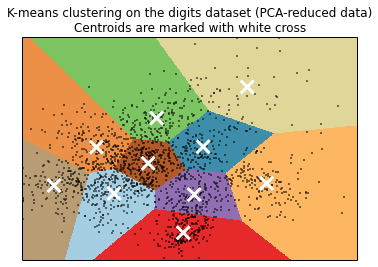

In [7]:
###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() + 1, reduced_data[:, 0].max() - 1
y_min, y_max = reduced_data[:, 1].min() + 1, reduced_data[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
pl.figure(1)
pl.clf()
pl.imshow(Z, interpolation='nearest',
          extent=(xx.min(), xx.max(), yy.min(), yy.max()),
          cmap=pl.cm.Paired,
          aspect='auto', origin='lower')

pl.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
pl.scatter(centroids[:, 0], centroids[:, 1],
           marker='x', s=169, linewidths=3,
           color='w', zorder=10)
pl.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
         'Centroids are marked with white cross')
pl.xlim(x_min, x_max)
pl.ylim(y_min, y_max)
pl.xticks(())
pl.yticks(())
pl.show()

### code grabbed from http://ufal.mff.cuni.cz/~straka/courses/npfl102/2014/handout09.pdf
from nl t k . t o k e ni z e import w o r d p u n c t t o k e ni z e

from pyspark import SparkConf , SparkContext

import s y s

if len ( s y s . argv ) < 4 :
pr int >>s y s . s t d e r r , ”Usage : %s master i n p u t output ” % s y s . argv [ 0 ]
e x i t ( 1 )
s c = SparkContext ( s y s . argv [ 1 ] , ”Word count ” )
f i l e = s c . t e x t F i l e ( s y s . argv [ 2 ] )
c oun t s = f i l e . flatMap (lambda x : w o r d p u n c t t o k e ni z e ( x ) ) \
. map(lambda x : ( x , 1 ) ) \
. reduceByKey (lambda x , y : x + y )
c oun t s .map(lambda ( x , y ) : ”%s\t%d” % ( x , y ) ) \
. s a veA sTe x tFile ( s y s . argv [ 3 ] )

#--------------------
Look here for some more examples: https://spark.apache.org/examples.html

# Now to try out some sparkSql stuff
see  http://spark.apache.org/docs/1.2.0/sql-programming-guide.html


In [32]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [41]:
# make sure the file I want exists
!hdfs dfs -ls /data/discovery/claimsff/derived/npi_study
#/#npi_study/col400file.csv

Found 2 items
-rw-rwx---+  3 kesj claimsff 14060222606 2015-03-16 12:59 /data/discovery/claimsff/derived/npi_study/col400file.csv
-rw-rwx---+  3 kesj claimsff 43598402123 2015-03-16 13:11 /data/discovery/claimsff/derived/npi_study/colnot400file.csv


In [42]:
# load a text file and convert each line to a row
lines = sc.textFile("/data/discovery/claimsff/derived/npi_study/col400file.csv")

In [43]:
lines.top(10)

[u'\xef\xbb\xbfPc to CO#8626, no vmb setup.<br>',
 u'\xef\xbb\xbfPc to CO#8626, no vmb setup.<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>',
 u'\xef\xbb\xbf<br>']

In [34]:
parts = lines.map(lambda l: l.split(","))

## comparing flatmap and map

In [84]:
hw_lines = sc.parallelize(["hello world!", "hello SparkWorld", "hi you-all", 'hello you-all','hi world!'])
hw_words_map = hw_lines.map(lambda line: line.split(" ")).coalesce(1)
hw_words_flatmap = hw_lines.flatMap(lambda line: line.split(" ")).coalesce(1)

In [70]:
hw_words_map.take(10)

[['hello', 'world!'], ['hello', 'SparkWorld'], ['hi']]

In [71]:
hw_words_flatmap.take(10)

['hello', 'world!', 'hello', 'SparkWorld', 'hi']

## Average by Key example

see http://abshinn.github.io/python/apache-spark/2014/10/11/using-combinebykey-in-apache-spark/

In [80]:
data = sc.parallelize([(0,2.),(0,4.),(1,0.),(1,10.),(1,20.)])
sumCount = data.combineByKey(lambda value: (value,1),
                             lambda x, value:(x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0],x[1]+y[1]))

In [82]:
sumCount.take(5)

[(0, (6.0, 2)), (1, (30.0, 3))]

In [83]:
averageByKey=sumCount.map(lambda (label, (value_sum, count)): (label, value_sum / count))
print averageByKey.collectAsMap()

{0: 3.0, 1: 10.0}


In [90]:
join_hw_words = hw_words_map.combineByKey(lambda value: (value,1),
                                          lambda x, value:(x[0]+value, x[1]+1),
                                          lambda x,y: (x[0]+y[0],x[1]+y[1]))

In [91]:
join_hw_words.take(5)

[('hi', ('you-allworld!', 2)), ('hello', ('world!SparkWorldyou-all', 3))]

In [92]:
hw_words_result = hw_words_map.groupByKey().collect()

In [100]:
print len(hw_words_result)
for result in hw_words_result:
    print result[0]
    print [a for a in result[1]]
#[a for a in hw_words_result[0][1]]

2
hi
['you-all', 'world!']
hello
['world!', 'SparkWorld', 'you-all']
